## Tutorial 1. Checking system and conda packages

In [1]:
# Add current directory to Path 
import sys 
sys.path.append('..')

# Import the enabol module
import enabol

[INFO] - hls4ml path imported from local dir /mnt/raid5/asic/projects/NU/ENABOL/manuelbv/hls4ml


2025-06-20 16:35:58.288332: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-20 16:35:58.290143: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-20 16:35:58.293690: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-06-20 16:35:58.303744: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750455358.322275 3056252 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750455358.32

[INFO] - hls4ml version: 0.6.0
[INFO] - Configuration loaded from /mnt/raid5/asic/projects/NU/ENABOL/manuelbv/enabol/config/config.yaml


/mnt/raid5/asic/projects/NU/ENABOL/manuelbv/hls4ml/converters/__init__.py:16: UserWarning: WARNING: Pytorch converter is not enabled!
  warnings.warn("WARNING: Pytorch converter is not enabled!")
/mnt/raid5/asic/projects/NU/ENABOL/manuelbv/hls4ml/converters/__init__.py:23: UserWarning: WARNING: ONNX converter is not enabled!
  warnings.warn("WARNING: ONNX converter is not enabled!")


X shape: (200, 1)
Y shape: (200, 1)


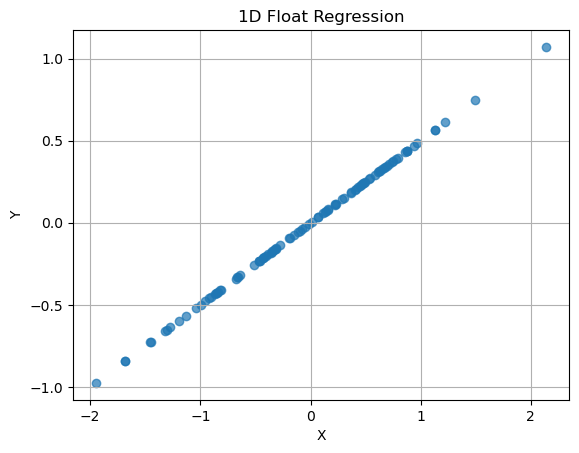

In [2]:
""" Create a simple Linear dataset (Y = 0.5*X) """
from enabol.dataset import LinearDataset

# Create a simple linear regression dataset
dataset = LinearDataset(n_samples = 200, weight = 0.5, noise_std = 0.0, seed = 42)

# Access the data 
X, Y = dataset.get()
print("X shape:", X.shape)
print("Y shape:", Y.shape)

# Visualize
dataset.plot()

In [3]:
""" build a simple model """
from enabol.nn import MLPModel

dataset = LinearDataset(n_samples=200, weight=0.5, seed=42)
model = MLPModel(dataset, units=[1], activations=False, use_bias=False,
                loss = 'mse', optimizer = 'adam', metrics = [])
model.summary()

2025-06-20 16:36:00.579070: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 1)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             1 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1 (4.00 B)

 Trainable params: 1 (4.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Define default precision as ap_fixed<16,6>
default_precision = enabol.dtypes.ap_fixed(16, 6)

# Set input layers precision 
precision = {ly.name: {'result': enabol.dtypes.ap_ufixed(16, 1)} for ly in model.layers if 'InputLayer' in ly.__class__.__name__}

# If one wants to set other precisions, do it like so:
# precision[<layer_name>] = {'result': enabol.dtypes.ap_fixed(17,5), 
#                               'weight': enabol.dtypes.ap_fixed(16,4),
#                               'bias': enabol.dtypes.ap_fixed(8,3)}

# COMPILE THE MODEL
hls_model, config = enabol.compile_model(model, 
                                         output_dir = "../sandbox",
                                         trainable = True,
                                         part = 'xcku035-fbva676-2-e',
                                         io_type = 'io_parallel',
                                         backend = 'Vivado',
                                         strategy = 'Latency',
                                         reuse_factor = 1,
                                         tracing = True,
                                         granularity = 'name',
                                         default_precision = default_precision, 
                                         verbose = True,
                                         overwrite = True)


[INFO] - /usr/bin already in PATH environment variable
[INFO] - Added /usr/lib/x86_64-linux-gnu:/usr/lib32: to LD_LIBRARY_PATH environment variable
[INFO] - Set LIBRARY_PATH to /usr/lib/x86_64-linux-gnu:/usr/lib32:
[INFO] - Set CC to /usr/bin/gcc-4.9
[INFO] - Set CXX to /usr/bin/g++-4.9
[INFO] - Set CPLUS_INCLUDE_PATH to /usr/include:/usr/include/c++/4.9:/usr/include/x86_64-linux-gnu
Interpreting Model
Topology:
Layer name: input_layer, layer type: Input
Layer name: dense, layer type: Dense
  -> Activation (linear), layer name: dense
[WARN] - Layer 'input_layer' is not a weight layer, skipping precision for weight and bias.
[WARN] - Layer 'dense' is not a weight layer, skipping precision for weight and bias.
[INFO] - HLS4ML configuration:
{
  "Model": {
    "Precision": "ap_fixed<16,6>",
    "ReuseFactor": 1,
    "Strategy": "Latency",
    "Trainable": true,
    "Losses": [
      "mse"
    ]
  },
  "LayerName": {
    "input_layer": {
      "Precision": {
        "result": "ap_fixed<17,

Done


In [ ]:
!echo $CPLUS_INCLUDE_PATH
!gcc -xc++ -E -v - </dev/null

In [ ]:


!which gcc
!gcc --version

In [ ]:
!ls /usr/bin/gcc*